In [1]:
from pathlib import Path
from math import floor,log10
import json
from src.data_structures import Instance
from matplotlib import pyplot as plt
import numpy as np
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [2]:
#Cargo las instancias, y los resultados desde cada carpeta, y los combino
results_path = Path("final_results")
baldo_data_path = Path("baldo_test_data")
files = results_path.iterdir()
names_to_use = [file.name for file in files]
instances = [] 
for file in names_to_use:
    instance = Instance.from_file(baldo_data_path/file)
    instance.file_name = file
    instances.append(instance)
    result = open(results_path/instance.file_name,"r")
    result_data = json.load(result)
    result.close()
    instance.result = result_data
instances.sort(key=lambda x: x.n_items)

In [3]:
matrix = []
for instance in instances:
    if instance.result["Solver_of"] == -1:
        continue
    if instance.result["BaldoML_of"] == -1:
        continue

    sol_of = instance.result["Solver_of"]
    sol_time = instance.result["Solver_time"] + 1
    gap = lambda instance,x: ((instance.result["Solver_of"]-instance.result[x])/instance.result["Solver_of"])
    points = []
    points.append((gap(instance,f"BaldoGA_of"),(instance.result[f"BaldoGA_time"])/sol_time))
    points.append((gap(instance,f"BaldoML_of"),(instance.result[f"BaldoML_time"])/sol_time))
    for i in range(1,2):
        threshold = round(0.05*i,3)
        points.append((gap(instance,f"Z_threshold{threshold}_of"),(instance.result[f"Z_threshold{threshold}_time"]/sol_time)))
    matrix.append(points)
matrix = np.array(matrix)


In [46]:
matrix_times = []
for instance in instances:
    if instance.result["Solver_of"] == -1:
        continue
    if instance.result["BaldoML_of"] == -1:
        continue

    sol_of = instance.result["Solver_of"]
    sol_time = instance.result["Solver_time"] + 1
    gap = lambda instance,x: ((instance.result["Solver_of"]-instance.result[x])/instance.result["Solver_of"])
    points = []
    points.append((gap(instance,f"BaldoGA_of"),(instance.result[f"BaldoGA_time"])))
    points.append((gap(instance,f"BaldoML_of"),(instance.result[f"BaldoML_time"])))
    for i in range(1,2):
        threshold = round(0.05*i,3)
        points.append((gap(instance,f"Z_threshold{threshold}_of"),(instance.result[f"Z_threshold{threshold}_time"])))
    matrix_times.append(points)
matrix_times = np.array(matrix_times)


Text(0.5, 0, '$\tau$')

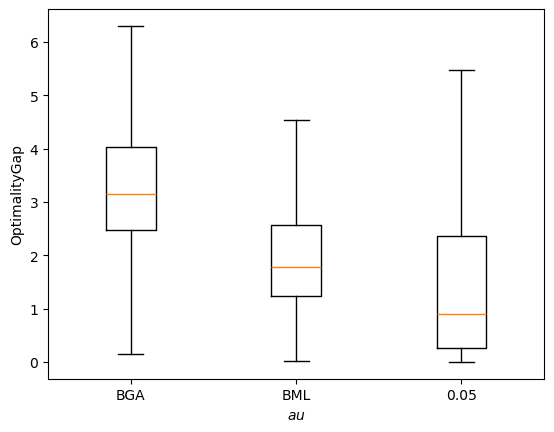

In [4]:
#Boxplot del Gap con distintos Tau y otros metodos
#matrix[instance,solver,gap]
bplot = plt.boxplot(matrix[:,:,0]*100,showfliers=False)
plt.xticks([i for i in range(1,4)],["BGA","BML"]+[str(round(i,3)) for i in range(1,2)])
plt.ylabel("OptimalityGap")
plt.rc("text",usetex=True)
plt.xlabel('$\tau$')


In [5]:
#Boxplot del Gap con distintos Tau y otros metodos

print(np.average(matrix[1,:,0]))




0.041713826507900086


{'whiskers': [<matplotlib.lines.Line2D object at 0x7febfb258590>, <matplotlib.lines.Line2D object at 0x7febfb258d50>, <matplotlib.lines.Line2D object at 0x7febfb268350>, <matplotlib.lines.Line2D object at 0x7febfb268c50>, <matplotlib.lines.Line2D object at 0x7febfb2741d0>, <matplotlib.lines.Line2D object at 0x7febfb274a90>], 'caps': [<matplotlib.lines.Line2D object at 0x7febfb259690>, <matplotlib.lines.Line2D object at 0x7febfb259f10>, <matplotlib.lines.Line2D object at 0x7febfb269550>, <matplotlib.lines.Line2D object at 0x7febfb269ed0>, <matplotlib.lines.Line2D object at 0x7febfb275350>, <matplotlib.lines.Line2D object at 0x7febfb275bd0>], 'boxes': [<matplotlib.lines.Line2D object at 0x7febfb22fcd0>, <matplotlib.lines.Line2D object at 0x7febfb25ba50>, <matplotlib.lines.Line2D object at 0x7febfb26b910>], 'medians': [<matplotlib.lines.Line2D object at 0x7febfb25a810>, <matplotlib.lines.Line2D object at 0x7febfb26a650>, <matplotlib.lines.Line2D object at 0x7febfb276450>], 'fliers': [], '

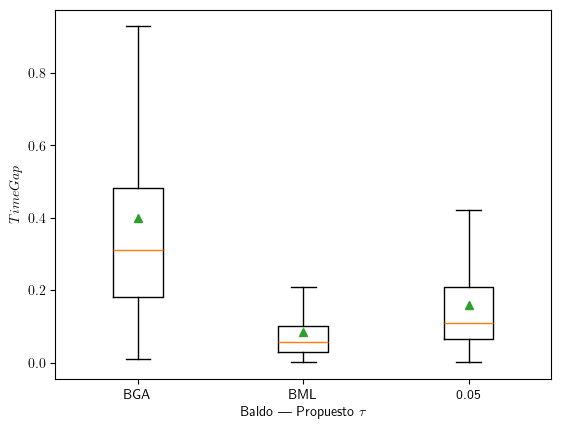

In [6]:
#Boxplot del TimeGap con distintos tau
#matrix[instance,solver,gap]
bplot = plt.boxplot(matrix[:,:,1],showmeans=True,showfliers=False)
plt.xticks([i for i in range(1,4)],["BGA","BML"]+[str(round(i*0.05,3)) for i in range(1,2)])
plt.ylabel(r"$TimeGap$")
plt.xlabel(r'Baldo | Propuesto $\tau$')
plt.savefig("assets/full_timegap_comparison.png")
print(bplot)


In [56]:
np.mean(matrix[:,0,0])*100

3.297925569305797

In [47]:
from itertools import groupby

def by_size_performance(metodo: str,plot=True):
    by_size_instances = groupby(instances,key=lambda ins: ins.n_items)
    sizes = []
    keys  = []
    for key, group in by_size_instances:
        points = []
        keys.append(key)
        for instance in group:
            if instance.result["Solver_of"] == -1:
                continue
            sol_of = instance.result["Solver_of"]
            sol_time = instance.result["Solver_time"] + 1
            gap = lambda instance,x: ((instance.result["Solver_of"]-instance.result[x])/instance.result["Solver_of"])
            points.append((gap(instance,f"{metodo}_of"),(instance.result[f"{metodo}_time"])))
        sizes.append(np.array(points))
    data_to_plot = [points[:,0] for points in sizes]
    if plot:
        boxplot = plt.boxplot(data_to_plot,showfliers=False)
    return sizes



In [52]:
metodo = "Z_threshold0.05"
sizes = by_size_performance(metodo,plot=False)
gaps_by_size = [points[:,0] for points in sizes]
times_by_size = [points[:,1] for points in sizes]

sizes = map(str,[100,300,500,700,900,1100,1300,1500])
mean_of_gaps_bu_size = map(str,map(np.mean,gaps_by_size))
std_of_gaps_bu_size = map(str,map(np.std,gaps_by_size))

mean_of_times_bu_size = map(str,map(np.mean,times_by_size))
std_of_times_bu_size = map(str,map(np.std,times_by_size))

print(f"{metodo} Gap by size")
print(" ".join(sizes))
print(" ".join(mean_of_gaps_bu_size))
print(" ".join(std_of_gaps_bu_size))

print(f"{metodo} Times by size")
print(" ".join(sizes))
print(" ".join(mean_of_times_bu_size))
print(" ".join(std_of_times_bu_size))



Z_threshold0.05 Gap by size
100 300 500 700 900 1100 1300 1500
0.024523060696971247 0.017930912732955533 0.013656865084736179 0.013972732034107349 0.014119631542699648 0.014003939601784782 0.012349254118141402 0.010168570840402402
0.025008416700944204 0.017004588316885987 0.013519310562994097 0.013576709821532138 0.013814389637729133 0.01376645511862926 0.012789226428768962 0.011549761174537572
Z_threshold0.05 Times by size

0.19535078287124633 0.876966804265976 1.46446729183197 2.6097128834556695 3.7998940055234445 3.4084959431570403 4.667619434595108 6.278941612147806
0.09239795383245775 0.3711363062517115 1.053369526583104 2.055203219335946 2.9664308099871217 2.7289814546306 3.4713010691920396 4.486459713396113


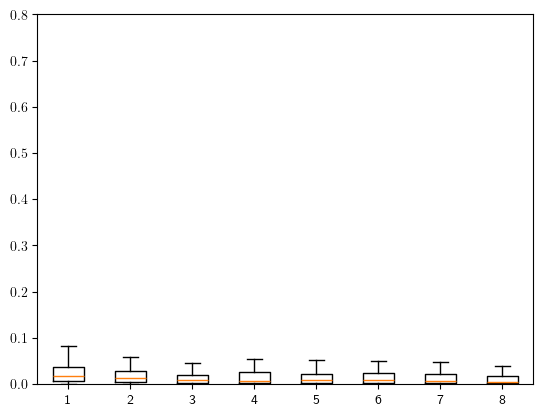

In [49]:
sizes = by_size_performance("Z_threshold0.05",plot=False)
z_data = [points[:,0] for points in sizes]
plt.figure()
plt.ylim(0,0.8)

a = plt.boxplot(z_data,showfliers=False)


In [50]:
z_meanofmean = np.mean([np.mean(group) for group in z_data])
baldo_meanofmean = np.mean([np.mean(group) for group in baldo_data])
(z_meanofmean-baldo_meanofmean)*100

-0.5388805488869358

Hipotesis nula de igualdad 16.719998426118384 3.294239105606895e-60
Datos baldo media: 8.581260749965006, std: 9.331827986564607
Datos z media: 15.93721548893686, std: 14.828893796344902
Diferencia de medias: -7.355954738971853


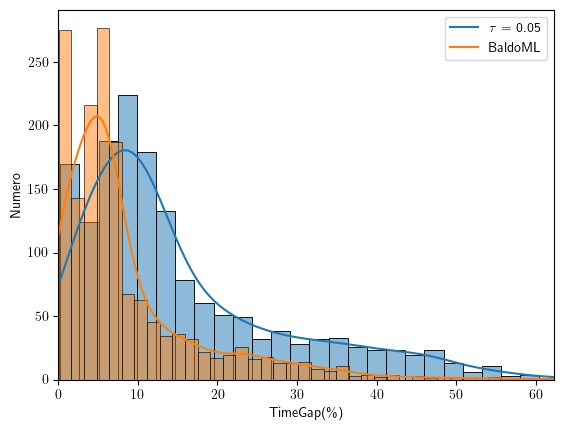

In [51]:
import seaborn as sns
import math
import scipy.stats as stats

measure = 1
baldo_data = matrix[:,1,measure]
z_data =     matrix[:,2,measure]

plt.figure()
sns.histplot(z_data*100,kde=True,bins=50)
sns.histplot(baldo_data*100,kde=True,bins=50)

#Comparacion de varianzas
n = len(z_data)

estadistico, p = stats.ttest_ind(list(z_data),list(baldo_data))
print("Hipotesis nula de igualdad",estadistico,p)
print(f"Datos baldo media: {np.mean(baldo_data*100)}, std: {np.std(baldo_data*100)}")
print(f"Datos z media: {np.mean(z_data*100)}, std: {np.std(z_data*100)}")
print(f"Diferencia de medias: {np.mean(baldo_data*100) - np.mean(z_data*100)}")
#Prueba F para determinar si son lo suficientemente iguales para hacer una prueba ttest_int

plt.xlim(0,np.percentile(z_data*100,99))

plt.xlabel(r"TimeGap(\%)")
plt.ylabel(r"Numero")
plt.legend(labels=[r"$\tau$ = 0.05","BaldoML"])

